## Topic Modelling

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [13]:
import sys
import os
#!{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import nltk

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
import gensim.utils
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [20]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [21]:
### from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'could', 'also'])

## Loading data

In [15]:
df = pd.read_csv('data/courses.csv')
df = df.fillna("")
df.columns

Index(['ID', 'Country', 'Univeristy', 'G2RWorldRank', 'G2RNationalRank',
       'QSWorldUniversityRanking2021', 'Program',
       'SchoolOfferingCourseProgram', 'CourseDescription', 'Course Unit',
       'CourseUnitGoals', 'CourseUnitOutcomes'],
      dtype='object')

In [16]:
df ['summary'] = df['CourseDescription'] + df['CourseUnitGoals'] + df['CourseUnitOutcomes']
data = list(df['summary'])
len(data)

503

## Tokenizing and cleaning data

In [17]:
from gensim.utils import simple_preprocess
def clean_text(texts):
    for sent in texts:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data_0  = list(clean_text(data))

## Bigrams-Trigrams Models

In [26]:
xx= pd.Series(nltk.ngrams(data_0, 1)).value_counts()
as_dataframe= xx.to_frame("count")
reqd_Index = as_dataframe[as_dataframe['count']<=100].index.tolist()
lowest_frequency_unigrams =[]
for element in reqd_Index:
    lowest_frequency_unigrams.append(element)
lowest_frequency_unigrams.append("1")
lowest_frequency_unigrams.append("\ufeff1")

print ("lowest_frequency_unigrams",len(lowest_frequency_unigrams))

data =[]
for text in data_0:
    temporal_variable=[]
    for word in text:
        if word not in lowest_frequency_unigrams:
            temporal_variable.append(word)
    temporal_variable= " ".join(temporal_variable)
    data.append(temporal_variable)
    
#12
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

lowest_frequency_unigrams 475
[['our', 'graduates', 'will', 'be', 'experts', 'solving', 'problems', 'by', 'applying', 'ece', 'fundamentals', 'building', 'solutions', 'that', 'reflect', 'depth', 'of', 'understanding', 'in', 'their', 'sophistication', 'and', 'breadth', 'of', 'understanding', 'by', 'drawing', 'on', 'multiple', 'disciplines', 'innovators', 'demonstrating', 'creativity', 'in', 'their', 'engineering', 'practice', 'considering', 'holistic', 'systems', 'oriented', 'approaches', 'in', 'their', 'designs', 'thinking', 'strategically', 'in', 'their', 'planning', 'and', 'execution', 'and', 'leaders', 'taking', 'initiative', 'demonstrating', 'resourcefulness', 'collaborating', 'in', 'teams', 'and', 'leading', 'in', 'their', 'organizations', 'their', 'profession', 'and', 'in', 'society', 'an', 'ability', 'to', 'identify', 'formulate', 'and', 'solve', 'complex', 'engineering', 'problems', 'by', 'applying', 'principles', 'of', 'engineering', 'science', 'and', 'mathematics', 'an', 'abil

In [28]:
bigram = gensim.models.Phrases(data_words, min_count=50, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/yadira/.virtualenvs/ai-nlp-docs/lib/python3.8/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['our', 'graduates', 'will', 'be', 'experts', 'solving', 'problems', 'by', 'applying', 'ece', 'fundamentals', 'building', 'solutions', 'that', 'reflect', 'depth', 'of', 'understanding', 'in', 'their', 'sophistication', 'and', 'breadth', 'of', 'understanding', 'by', 'drawing', 'on', 'multiple', 'disciplines', 'innovators', 'demonstrating', 'creativity', 'in', 'their', 'engineering', 'practice', 'considering', 'holistic', 'systems', 'oriented', 'approaches', 'in', 'their', 'designs', 'thinking', 'strategically', 'in', 'their', 'planning', 'and', 'execution', 'and', 'leaders', 'taking', 'initiative', 'demonstrating', 'resourcefulness', 'collaborating', 'in', 'teams', 'and', 'leading', 'in', 'their', 'organizations', 'their', 'profession', 'and', 'in', 'society', 'an', 'ability', 'to', 'identify_formulate', 'and', 'solve', 'complex', 'engineering', 'problems', 'by', 'applying', 'principles', 'of', 'engineering', 'science', 'and', 'mathematics', 'an', 'ability', 'to', 'apply', 'engineering'

In [29]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [32]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

nlp = spacy.load("en_core_web_sm")


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['graduate', 'be', 'expert', 'solve', 'problem', 'apply', 'ece', 'fundamental', 'building', 'solution', 'reflect', 'depth', 'understanding', 'sophistication', 'breadth', 'understanding', 'draw', 'multiple', 'discipline', 'innovator', 'demonstrate', 'creativity', 'engineering', 'practice', 'consider', 'holistic', 'system', 'orient', 'approach', 'design', 'think', 'strategically', 'planning', 'execution', 'leader', 'take', 'initiative', 'demonstrate', 'resourcefulness', 'collaborating', 'team', 'lead', 'organization', 'profession', 'society', 'ability', 'identify', 'formulate', 'solve', 'complex', 'engineering', 'problem', 'apply', 'principle', 'engineering', 'science', 'mathematic', 'ability', 'apply', 'engineering', 'design', 'produce', 'solution', 'meet', 'specify', 'need', 'consideration', 'public', 'health', 'safety', 'welfare', 'as', 'well', 'global', 'cultural', 'social', 'environmental', 'economic', 'factor', 'ability', 'communicate', 'effectively', 'range', 'audience', 'ability

In [33]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=50, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['our', 'graduates', 'will', 'be', 'experts', 'solving', 'problems', 'by', 'applying', 'ece', 'fundamentals', 'building', 'solutions', 'that', 'reflect', 'depth', 'of', 'understanding', 'in', 'their', 'sophistication', 'and', 'breadth', 'of', 'understanding', 'by', 'drawing', 'on', 'multiple', 'disciplines', 'innovators', 'demonstrating', 'creativity', 'in', 'their', 'engineering', 'practice', 'considering', 'holistic', 'systems', 'oriented', 'approaches', 'in', 'their', 'designs', 'thinking', 'strategically', 'in', 'their', 'planning', 'and', 'execution', 'and', 'leaders', 'taking', 'initiative', 'demonstrating', 'resourcefulness', 'collaborating', 'in', 'teams', 'and', 'leading', 'in', 'their', 'organizations', 'their', 'profession', 'and', 'in', 'society', 'an', 'ability', 'to', 'identify_formulate', 'and', 'solve', 'complex', 'engineering', 'problems', 'by', 'applying', 'principles', 'of', 'engineering', 'science', 'and', 'mathematics', 'an', 'ability', 'to', 'apply', 'engineering'

In [34]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 7), (1, 1), (2, 1), (3, 4), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 2), (33, 7), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 3), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 1), (105, 2), (106, 2), (107, 1), (108, 1)]]


In [35]:
#12.0
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

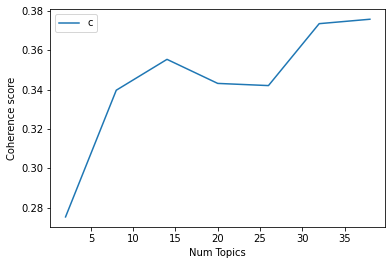

In [37]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
for m, cv in zip (x,coherence_values):
    print ("num topics= ", m, "has Coherence Value of", round (cv,4))

num topics=  2 has Coherence Value of 0.2752
num topics=  8 has Coherence Value of 0.3397
num topics=  14 has Coherence Value of 0.3554
num topics=  20 has Coherence Value of 0.3432
num topics=  26 has Coherence Value of 0.3421
num topics=  32 has Coherence Value of 0.3736
num topics=  38 has Coherence Value of 0.3759


In [39]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.076*"security" + 0.043*"privacy" + 0.030*"forensic" + 0.024*"usability" + 0.023*"policy" + 0.022*"system" + 0.021*"network" + 0.020*"include" + 0.019*"trust" + 0.018*"public"'), (1, '0.029*"technology" + 0.021*"how" + 0.020*"cryptography" + 0.020*"encourage" + 0.019*"home" + 0.018*"mediate" + 0.018*"active" + 0.018*"social" + 0.016*"science" + 0.014*"course"'), (2, '0.029*"engineering" + 0.020*"paper" + 0.019*"function" + 0.015*"problem" + 0.014*"ability" + 0.014*"student" + 0.012*"provide" + 0.012*"make" + 0.012*"design" + 0.011*"use"'), (3, '0.028*"engineering" + 0.018*"research" + 0.018*"be" + 0.018*"software" + 0.016*"skill" + 0.015*"science" + 0.012*"able" + 0.011*"discipline" + 0.010*"societal" + 0.010*"system"'), (4, '0.052*"datum" + 0.041*"healthcare" + 0.036*"ai" + 0.021*"use" + 0.020*"analytic" + 0.020*"learn" + 0.018*"student" + 0.018*"problem" + 0.018*"technique" + 0.018*"practical"'), (5, '0.064*"datum" + 0.025*"data" + 0.024*"module" + 0.019*"analysis" + 0.015*"da

In [40]:
print(optimal_model.print_topics())
doc_lda = optimal_model[corpus]

[(0, '0.076*"security" + 0.043*"privacy" + 0.030*"forensic" + 0.024*"usability" + 0.023*"policy" + 0.022*"system" + 0.021*"network" + 0.020*"include" + 0.019*"trust" + 0.018*"public"'), (1, '0.029*"technology" + 0.021*"how" + 0.020*"cryptography" + 0.020*"encourage" + 0.019*"home" + 0.018*"mediate" + 0.018*"active" + 0.018*"social" + 0.016*"science" + 0.014*"course"'), (2, '0.029*"engineering" + 0.020*"paper" + 0.019*"function" + 0.015*"problem" + 0.014*"ability" + 0.014*"student" + 0.012*"provide" + 0.012*"make" + 0.012*"design" + 0.011*"use"'), (3, '0.028*"engineering" + 0.018*"research" + 0.018*"be" + 0.018*"software" + 0.016*"skill" + 0.015*"science" + 0.012*"able" + 0.011*"discipline" + 0.010*"societal" + 0.010*"system"'), (4, '0.052*"datum" + 0.041*"healthcare" + 0.036*"ai" + 0.021*"use" + 0.020*"analytic" + 0.020*"learn" + 0.018*"student" + 0.018*"problem" + 0.018*"technique" + 0.018*"practical"'), (5, '0.064*"datum" + 0.025*"data" + 0.024*"module" + 0.019*"analysis" + 0.015*"da

In [41]:
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word,mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.152526  0.241887       1        1  29.142106
4      0.127507  0.360492       2        1  14.368988
3      0.312341 -0.086881       3        1  13.597115
6     -0.354484  0.023251       4        1  12.627787
2      0.205999  0.089815       5        1  11.914489
1     -0.057422 -0.033703       6        1   8.775594
0     -0.210399 -0.299067       7        1   5.843789
5      0.128984 -0.295794       8        1   3.730132, topic_info=            Term        Freq       Total Category  logprob  loglift
23         datum  319.000000  319.000000  Default  30.0000  30.0000
286        human  240.000000  240.000000  Default  29.0000  29.0000
480     security  141.000000  141.000000  Default  28.0000  28.0000
1049  healthcare  187.000000  187.000000  Default  27.0000  27.0000
26        design  239.000000  239.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
228      machine    8.583233   93.041897   Topic8  -4.9211   0.9055
76     principle    7.296931   47.334432   Topic8  -5.0835   1.4189
203         such    6.624738  107.905209   Topic8  -5.1801   0.4983
2        analyze    4.992059   47.165656   Topic8  -5.4631   1.0429
172     decision    4.765273   53.906290   Topic8  -5.5096   0.8628

[485 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         5  0.985367         ability
512       1  0.176549            able
512       3  0.818546            able
454       7  0.907224          access
1456      8  0.948541  accountability
...     ...       ...             ...
342       3  0.122998            work
342       4  0.217612            work
342       6  0.141921            work
342       7  0.122998            work
159       1  0.969415            year

[754 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 7, 3, 2, 1, 6])

In [42]:
#12.6 Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(21, '0.031*"strengthen" + 0.031*"password" + 0.031*"remote" + 0.024*"equipment" + 0.016*"scanning" + 0.016*"file" + 0.016*"customize" + 0.016*"vulnerable" + 0.016*"install" + 0.016*"trojan"'), (30, '0.060*"genetic" + 0.048*"engineering" + 0.046*"independent" + 0.027*"reading" + 0.026*"biotechnology" + 0.019*"essay" + 0.019*"appreciation" + 0.018*"format" + 0.016*"gap" + 0.014*"enter"'), (27, '0.254*"mediate" + 0.042*"introductory" + 0.019*"look" + 0.018*"engagement" + 0.016*"climate" + 0.014*"controversial" + 0.012*"count" + 0.012*"american" + 0.010*"treat" + 0.010*"danger"'), (34, '0.098*"teach" + 0.076*"faculty" + 0.045*"session" + 0.032*"member" + 0.030*"laboratory" + 0.025*"full" + 0.020*"academic" + 0.020*"outline" + 0.015*"tutorial" + 0.013*"classroom"'), (23, '0.132*"aspect" + 0.035*"rule" + 0.030*"employment" + 0.018*"ethically" + 0.017*"automation" + 0.014*"man" + 0.014*"supervisor" + 0.012*"integration" + 0.012*"discourse" + 0.011*"internship"'), (0, '0.045*"communication" 